# Iterated Prisoner's Dilemma On A Network

In [11]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from tqdm import tqdm
from Prison import experiment, ReinforcementLearningStrategy, NetworkSimulation
from IPython.display import Image

In [12]:
# --- CONFIGURATION ---
N_SIDE = 20           # 40x40 grid = 1600 agents
STEPS = 100          # Steps for strategies to settle
TRIALS = 30            # Average over a few trials for smoothness
BETAS = np.linspace(0.0, 5.0, 20) # Sweep b/c from 0 to 12
RL_KWARGS = {'learning_rate': 0.15, 'epsilon': 0.2, 'initial_q': 5.0}

def calculate_percolation_metrics(simulation):
    """
    Calculates S_max (Giant Component size) and Chi (Susceptibility).
    """
    state = simulation._get_state()
    # Identify Cooperators (Action 0 is C in logic if mapped correctly, usually C=0, D=1)
    # Check Prison.py: ActionStrategy defaults C/D. Simulation state maps D->1, C->0.
    coop_nodes = [n for n, val in state.items() if val == 0] 
    
    N = simulation.graph.number_of_nodes()
    
    if not coop_nodes:
        return 0.0, 0.0

    # Build subgraph of Cooperators
    G_coop = simulation.graph.subgraph(coop_nodes)
    components = list(nx.connected_components(G_coop))
    sizes = sorted([len(c) for c in components], reverse=True)
    
    # Order Parameter: Normalized Size of Giant Component
    S_max = sizes[0] / N 
    
    # Susceptibility: Weighted average of smaller clusters
    other_sizes = sizes[1:]
    if not other_sizes:
        chi = 0.0
    else:
        numerator = sum(s**2 for s in other_sizes)
        denominator = sum(other_sizes)
        chi = numerator / denominator if denominator > 0 else 0.0
        
    return S_max, chi

In [13]:
print(f"Running Experiment: Reinforcement Learning...")

results_rl = []

for beta in tqdm(BETAS):
    # Setup Payoff: b/c = beta * 4
    kbar = 4; c = 1.0; b = beta * kbar * c
    pm = {
        ("C", "C"): (b - c, b - c), ("C", "D"): (-c, b),
        ("D", "C"): (b, -c),        ("D", "D"): (0, 0),
    }

    s_max_list = []
    chi_list = []
    
    for _ in range(TRIALS):
        sim = NetworkSimulation(
            kind="grid",
            n=N_SIDE*N_SIDE,
            payoff_matrix=pm,
            strategy=ReinforcementLearningStrategy,
            # Q-learning params: learning_rate (alpha) and exploration (epsilon)
            strategy_kwargs=RL_KWARGS,
            history_window=5,   
            store_history=True,
            store_snapshots=False
        )
        
        sim.run_until_attractor(max_steps=STEPS, check_every=100, store_cycle_states=False)
        s_max, chi = calculate_percolation_metrics(sim)
        
        s_max_list.append(s_max)
        chi_list.append(chi)
        
    results_rl.append({
        "strategy": "RL",
        "b_over_c": b/c,
        "S_max_mean": np.mean(s_max_list),
        "chi_mean": np.mean(chi_list),
        "chi_std": np.std(chi_list)
    })

df_rl = pd.DataFrame(results_rl)
print("RL Experiment Complete.")

Running Experiment: Reinforcement Learning...


100%|██████████| 20/20 [01:29<00:00,  4.48s/it]

RL Experiment Complete.


NameError: name 'title' is not defined

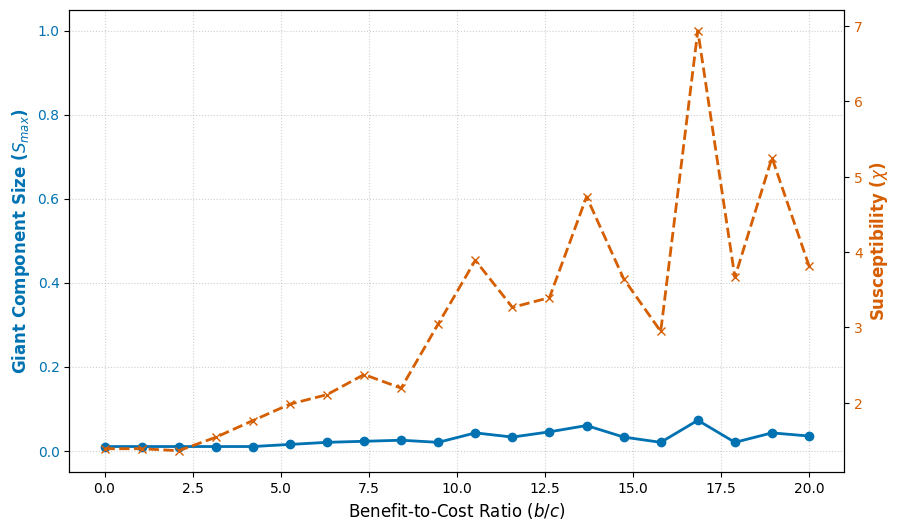

In [16]:
# --- Single Plot Configuration ---
fig, ax1 = plt.subplots(figsize=(10, 6))

# Unpack the single experiment data
# (Assuming experiments list has 1 item, or you can pass df_rl directly)
df = df_rl

# --- Left Axis: S_max (Blue) ---
color1 = '#0072B2' # High-contrast Blue
ax1.set_xlabel(r'Benefit-to-Cost Ratio ($b/c$)', fontsize=12)
ax1.set_ylabel(r'Giant Component Size ($S_{max}$)', color=color1, fontsize=12, fontweight='bold')

# Plot S_max
ax1.plot(df['b_over_c'], df['S_max_mean'], color=color1, marker='o', linewidth=2, label=r'$S_{max}$')

# Add Error Region (Standard Deviation)
# Check if 'chi_std' was the intended error metric for S_max, usually it's S_max_std. 
# If S_max_std exists in your df, use that. Otherwise, keeping your logic:
error_val = df['S_max_std'] if 'S_max_std' in df.columns else df['chi_std'] * 0.01
ax1.fill_between(df['b_over_c'], 
                 df['S_max_mean'] - error_val, 
                 df['S_max_mean'] + error_val, 
                 color=color1, alpha=0.1)

ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, linestyle=':', alpha=0.6)

# --- Right Axis: Susceptibility (Red) ---
ax2 = ax1.twinx()
color2 = '#D55E00' # High-contrast Red
ax2.set_ylabel(r'Susceptibility ($\chi$)', color=color2, fontsize=12, fontweight='bold')

# Plot Chi
ax2.plot(df['b_over_c'], df['chi_mean'], color=color2, linestyle='--', marker='x', linewidth=2, label=r'$\chi$')
ax2.tick_params(axis='y', labelcolor=color2)

# Global Title and Layout
plt.title(title, fontsize=14, pad=15)
plt.tight_layout()
plt.show()

In [ ]:
# 1. FIND THE CRITICAL POINT
# We look for the b/c value where Susceptibility (chi) was highest in your last run.
# If df_rl (or df) doesn't exist, we default to 4.5 (typical for grids).
try:
    # Change 'df_rl' to 'df' if you used the single plot code
    target_df = df_rl 
    critical_row = target_df.loc[target_df['chi_mean'].idxmax()]
    critical_bc = critical_row['b_over_c']
    print(f"Auto-detected Critical Point: b/c = {critical_bc:.2f}")
except NameError:
    critical_bc = 4.5
    print(f"Dataframe not found. Defaulting to known Critical Point: b/c = {critical_bc}")

critical_bc = 4.5

# 2. SETUP CONFIGURATION
# We need a bit more time (steps) to see the full evolution at the critical point
steps = 600 
n_side = 20  # Larger grid (50x50) makes the animation look much better
kbar = 4
c = 1.0
b = critical_bc * c

# Define the Payoff Matrix for this specific point
pm_critical = {
    ("C", "C"): (b - c, b - c),
    ("C", "D"): (-c, b),
    ("D", "C"): (b, -c),
    ("D", "D"): (0, 0),
}

# 3. RUN ANIMATION
# Note: Changing strategy to ImitationStrategy often yields cleaner 
# visual clusters for animation, but RL works too.
print("Generating Animation... (This may take a minute)")

anim_path = "critical_point_transition.gif"

gif = experiment(
    NetworkSimulation,
    strategy_class=ReinforcementLearningStrategy, # Or ImitationStrategy
    strategy_kwargs=RL_KWARGS,
    steps=steps,
    seed=42,             # Fixed seed for reproducibility
    interval=75,         # Speed of animation (ms per frame)
    payoff_matrix=pm_critical,
    title=f"Critical Phase Transition (b/c = {critical_bc:.2f})",
    kind="grid",
    n=n_side*n_side,     # 2500 agents
    is_grid=True,        # Render as a pixel grid
    save_gif=False,
    gif_path=anim_path
)

print(f"Animation saved to {anim_path}")
display(gif)

Dataframe not found. Defaulting to known Critical Point: b/c = 4.5
Generating Animation... (This may take a minute)


NameError: name 'NetworkSimulation' is not defined